# Data description

The dataset we are using for analysis:
* Segmenting and Clustering Neighborhoods in New York City :https://codekarim.com/node/57
* NYPD Arrest Data: https://www.kaggle.com/datasets/thaddeussegura/nypd-arrest-data-20062019
* NYC Airbnb Data: https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data
* NYC property Sales: https://www.kaggle.com/datasets/johnshuford/new-york-city-property-sales
* NYC motor vehicle collision: https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95

## Data preprocessing

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import font_manager as fm
from  matplotlib import cm
import json
import os
import requests
from pandas.io.json import json_normalize
import glob
from scipy import stats
import scipy
from utils import *

In [ ]:
crimeData = pd.read_csv("Data/NYPD_Arrests_Data__Historic_.csv").dropna()
collisionData = pd.read_csv("Data/Motor_Vehicle_Collisions_-_Crashes.csv")
airbnbData = pd.read_csv("Data/AB_NYC_2019.csv").dropna()

### variables in the crime data

In [ ]:
print (crimeData.dtypes)

### variables in the collision data

In [ ]:
print (collisionData.dtypes)

### variables in the airbnb data

In [ ]:
print (airbnbData.dtypes)

## Show crime distribution from NYPD in pie chart

In [ ]:
def plotPieChart(data,label,title):
    fig, axes = plt.subplots(figsize=(15,15),ncols=2)
    ax1, ax2 = axes.ravel()

    colors = cm.rainbow(np.arange(len(data))/len(data))# colormaps: Paired, autumn, rainbow, gray,spring,Darks
    patches, texts, autotexts = ax1.pie(data, labels=labels, autopct='%1.0f%%',
        shadow=False, startangle=170, colors=colors)

    ax1.axis('equal')  
    
    proptease = fm.FontProperties()
    proptease.set_size('xx-small')
    # font size include: ‘xx-small’,x-small’,'small’,'medium’,‘large’,‘x-large’,‘xx-large’ or number, e.g. '12'
    plt.setp(autotexts, fontproperties=proptease)
    plt.setp(texts, fontproperties=proptease)

    ax1.set_title(title, loc='center')
    ax2.axis('off')
    ax2.legend(patches, labels, loc='center left')

    plt.tight_layout()
    plt.savefig('Demo_project_set_legend_good.jpg')
    plt.show()

In [ ]:
crimeData.head()

Let's take a look a the distrubation of crime type and where they happend

In [ ]:
typeCount = crimeData['OFNS_DESC']
typeCount = typeCount.value_counts(sort=True)
labels =typeCount.index
number = np.array(typeCount)

In [ ]:
plotPieChart(number,labels, "Crime Distribution")

Then, let's take a look a how these arrests distribute amoung boroughs.

In [ ]:
typeBorough = crimeData['ARREST_BORO']
typeBorough = typeBorough.replace(['K','Q','M','B','S'], ['BROOKLYN', 'QUEENS', 'MANHATTAN', 'BRONX', 'STATEN ISLAND'])
typeCountB = typeBorough.value_counts()
labels = typeCountB.index
numberB = np.array(typeCountB)
plotPieChart(typeCountB,labels,"Borough distribution")

Based on previous pie chart, we select severl crime that happens alot and might affect house rent and sale prices.
There Assault, theft, and trespassing. We check these types of crime separatly in different borough.

In [ ]:
crimeGivenBorough = crimeData[['OFNS_DESC','ARREST_BORO']]

In [ ]:
assult = crimeGivenBorough.loc[crimeGivenBorough['OFNS_DESC']=='ASSAULT 3 & RELATED OFFENSES']
theft = crimeGivenBorough.loc[crimeGivenBorough['OFNS_DESC']=='OTHER OFFENSES RELATED TO THEFT']
threspassing = crimeGivenBorough.loc[crimeGivenBorough['OFNS_DESC']=='CRIMINAL TRESPASS']

Lets plot them out

In [ ]:
data = assult['ARREST_BORO']
data = data.replace(['K','Q','M','B','S'], ['BROOKLYN', 'QUEENS', 'MANHATTAN', 'BRONX', 'STATEN ISLAND'])
data = data.value_counts()
labels = data.index
plotPieChart(data,labels,"Assults distribution in different borough")

In [ ]:
data = theft['ARREST_BORO']
data = data.replace(['K','Q','M','B','S'], ['BROOKLYN', 'QUEENS', 'MANHATTAN', 'BRONX', 'STATEN ISLAND'])
data = data.value_counts()
labels = data.index
plotPieChart(data,labels,"Theft distribution in different borough")

In [ ]:
data = threspassing['ARREST_BORO']
data = data.replace(['K','Q','M','B','S'], ['BROOKLYN', 'QUEENS', 'MANHATTAN', 'BRONX', 'STATEN ISLAND'])
data = data.value_counts()
labels = data.index
plotPieChart(data,labels,"Thresspassing distribution in different borough")

Lets now have a view of collision data and how these collision distributed among boroughs

In [ ]:
collisionData.head()

In [ ]:
collisionBorough = collisionData['BOROUGH']
collisionBorough = collisionBorough.value_counts()
labels = collisionBorough.index
plotPieChart(collisionBorough,labels,"Collision among boroughs")

In [ ]:
collisionBorough = collisionData['BOROUGH']
collisionBorough = collisionBorough.value_counts()
labels = collisionBorough.index
plotPieChart(collisionBorough,labels,"Collision among boroughs")

In [ ]:
collisionVehicle = collisionData['VEHICLE TYPE CODE 1']
collisionVehicle = collisionVehicle.value_counts();
collisionVehicle.head()

Here we try to analyze the different car type of collision in different boroughs.

In [ ]:
# this function extract exact number of collision in sedan,suv,taxi,and pick up truck in given borough.
def getBoroughDistribution(cityName,collisionData):
    borough = collisionData.loc[collisionData['BOROUGH']== cityName]
    borough = borough[borough['VEHICLE TYPE CODE 1'].notna()]
    borough['VEHICLE TYPE CODE 1'] = borough['VEHICLE TYPE CODE 1'].str.lower()
    borough.loc[borough['VEHICLE TYPE CODE 1'].str.contains('sedan'), 'VEHICLE TYPE CODE 1'] = 'sedan'
    borough.loc[borough['VEHICLE TYPE CODE 1'].str.contains('Sport'), 'VEHICLE TYPE CODE 1'] = 'SUV'
    sedanNum = len(borough.loc[borough['VEHICLE TYPE CODE 1'].str.contains('sedan')==True])
    pickUpNum = len(borough.loc[borough['VEHICLE TYPE CODE 1'].str.contains('pick')==True])
    taxiNum = len(borough.loc[borough['VEHICLE TYPE CODE 1'].str.contains('taxi')==True])
    SUVNum = len(borough.loc[borough['VEHICLE TYPE CODE 1'].str.contains('sport')==True])
    return [sedanNum,pickUpNum,taxiNum,SUVNum]

In [ ]:
brooklyn = getBoroughDistribution('BROOKLYN',collisionData)
queens = getBoroughDistribution('QUEENS',collisionData)
bronx = getBoroughDistribution('BRONX',collisionData)
island = getBoroughDistribution('STATEN ISLAND',collisionData)
manhattan = getBoroughDistribution('MANHATTAN',collisionData)

In [ ]:
columns = ["Sedan","Pick-up Truck", "Taxi","SUV"]
index = ['BROOKLYN','QUEENS','BRONX','STATEN ISLAND','MANHATTAN']
frames = [brooklyn,queens,bronx,island,manhattan]
frames = pd.DataFrame(frames,index = index,columns = columns)
frames

In [ ]:
frames.reset_index(inplace=True)
frames = frames.rename(columns = {'index':'Borough'})
frames

In [ ]:
frames.plot(x='Borough',y=["Sedan","Pick-up Truck","Taxi","SUV"],kind ='bar')

In [ ]:
airbnbData.head()

In [ ]:
avgData = airbnbData.groupby('neighbourhood_group')['price'].mean()
labels = avgData.index
labels

And let's plot out the average price of airbnb rent price in each borough.

In [ ]:
plt.bar(labels, avgData)
plt.show()

# Explore New York neighborhood data
Download and open json file from https://cocl.us/new_york_dataset

In [ ]:
with open('data/nyu_2451_34572-geojson.json') as json_data:
    newyork_data = json.load(json_data)

In [ ]:
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

Load json data into Pandas DataFrame

In [ ]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough.upper(),
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods

Define a function that calculate the distance between a given point and neighborhoods

In [ ]:
def get_neighborhood(location: tuple, borough: str) ->str:
    bor = neighborhoods.loc[neighborhoods.Borough == borough, ['Borough', 'Neighborhood', 'Latitude', 'Longitude']]
    bor['Distance'] = np.square(location[0] - bor['Latitude']) + np.square(location[1] - bor['Longitude'])
    min_index = bor['Distance'].idxmin()
    return bor.loc[min_index, 'Neighborhood']

In [ ]:
get_neighborhood((40.895437, -73.905643), 'BRONX')

Select data between 2017 and 2019 and drop the lines which have no location information

In [ ]:
collisionData = collisionData.dropna(subset=['BOROUGH', 'LATITUDE', 'LONGITUDE'], how='any')
collisionData['CRASH DATE'] = pd.to_datetime(collisionData['CRASH DATE'],format="%m/%d/%Y")
mask = (collisionData['CRASH DATE'] >= '2017-01-01') & (collisionData['CRASH DATE'] <= '2019-12-31')
collisionData_2017_2019 = collisionData.loc[mask].copy()
collisionData_2017_2019

In [ ]:
#for index, row in collisionData_2017_2019.iterrows():
 #   location = (row['LATITUDE'],row['LONGITUDE'])
  #  nbh = get_neighborhood(location, row['BOROUGH'])
   # collisionData_2017_2019.loc[index,'NBH'] = nbh

In [ ]:
#print(collisionData_2017_2019['NBH'])

## Get the neighborhood for crime

In [ ]:
#crimeData

In [ ]:
#crimeData['ARREST_DATE'] = pd.to_datetime(crimeData['ARREST_DATE'],format="%m/%d/%Y")
#mask = (crimeData['ARREST_DATE'] >= '2017-01-01') & (crimeData['ARREST_DATE'] <= '2019-12-31')
#crimeData_2017_2019 = crimeData.loc[mask].copy()
#crimeData_2017_2019

In [ ]:
#print(crimeData['ARREST_BORO'].unique())

In [ ]:
#print(neighborhoods['Borough'].unique())

"BORO_NM " represents the borough where suspects were arrested, which may differ from the borough where crime happened.

In [ ]:
#def getNameforBorough(letter:str)->str:
 #   if letter == 'M':
  #      borough= 'MANHATTAN'
   # elif letter =='B':
    #    borough= 'BRONX'
    #elif letter == 'K':
    #    borough= 'BROOKLYN'
    #elif letter == 'S':
     #   borough= 'STATEN ISLAND'
    #else:
     #   borough = 'QUEENS'
    #return borough

In [ ]:
#neighborhoods.loc[neighborhoods['Neighborhood'] == 'Morningside Heights']

In [ ]:
#collisionData_2017_2019.to_csv('data/collisionData_2017_2019.csv', index=False)
#crimeData_2017_2019.to_csv('data/crimeData_2017_2019.csv', index=False)

In [ ]:
collisionData_NBH = pd.read_csv('Data/collisionData_2017_2019.csv')
crimeData_NBH = pd.read_csv('Data/crimeData_2017_2019.csv')

In [ ]:
collisionData_NBH["NBH"]
crimeData_NBH["NBH"]

After we can find out which neighborhood a location is belong to, we now explore the sales data.

First we got our original data year to year in separate files of different borough. we need to merge it into one file first.

We use helper function from utils.py to process the data first and merge the data or each borough into one file

In [ ]:
BronxData = pd.read_csv("Data/Bronx-mergeData.csv").dropna(subset=['Unit Price'])
QueensData = pd.read_csv("Data/Queens-mergeData.csv").dropna(subset=['Unit Price'])
BrooklynData = pd.read_csv("Data/Brooklyn-mergeData.csv").dropna(subset=['Unit Price'])
ManhattanData = pd.read_csv("Data/Manhattan-mergeData.csv").dropna(subset=['Unit Price'])
StatenIslandData = pd.read_csv("Data/StatenIsland-mergeData.csv").dropna(subset=['Unit Price'])

For each Borough, we will find out the pick neighboor, we just pick from head and tail neighborhoods

In [ ]:
def pickNeighborhood(BoroughData):
    neighborhoods = BoroughData["Neighborhood"].unique()
    afterAverage = BoroughData.groupby('Neighborhood').agg({'Unit Price':'mean'})
    afterAverage = afterAverage.sort_values("Unit Price",ascending = False)
    return afterAverage

Now we have the most expansive and inexpansive 

In [ ]:
BronxData_selected = pickNeighborhood(BronxData)
QueensData_selected = pickNeighborhood(QueensData)
Brooklyn_selected = pickNeighborhood(BrooklynData)
Manhattan_selected = pickNeighborhood(ManhattanData)
StatenIsland_selected = pickNeighborhood(StatenIslandData)

In [ ]:
BronxData_selected

In [ ]:
def appendDataToBorough(selected_data,collisionDataSet,crimData):
    for index, row in selected_data.iterrows():
        selected_data.loc[index]
        collisions = collisionDataSet.loc[collisionDataSet["NBH"].str.upper()==index]
        crimes = crimData.loc[crimData["NBH"].str.upper()==index]
        collisionWithDeathNum = collisions.loc[collisions["NUMBER OF PERSONS KILLED"]>0].shape[0]
        collisionWithSedanNum = collisions.loc[collisions["VEHICLE TYPE CODE 1"].str.contains("Sedan")==True].shape[0]
        collisionWithSUVNum = collisions.loc[collisions["VEHICLE TYPE CODE 1"].str.contains("Sport")==True].shape[0]
        theftCrimeNum = crimes.loc[crimes["OFNS_DESC"].str.contains("THEFT")==True].shape[0]
        selected_data.loc[index,"collisionWithDeath"] = collisionWithDeathNum*100
        selected_data.loc[index,"collisionWithSedan"] = collisionWithSedanNum
        selected_data.loc[index,"collisionWithSUV"] = collisionWithSUVNum
        selected_data.loc[index,"theftCrime"] = theftCrimeNum
        selected_data.replace(0, np.nan, inplace=True)

In [ ]:
appendDataToBorough(QueensData_selected,collisionData_NBH,crimeData_NBH)
appendDataToBorough(BronxData_selected,collisionData_NBH,crimeData_NBH)
appendDataToBorough(Brooklyn_selected,collisionData_NBH,crimeData_NBH)
appendDataToBorough(Manhattan_selected,collisionData_NBH,crimeData_NBH)
appendDataToBorough(StatenIsland_selected,collisionData_NBH,crimeData_NBH)

In [ ]:
QueensData_selected

In [ ]:
QueensFinal = QueensData_selected.dropna(how="any")
BronxFinal = BronxData_selected.dropna(how="any")
BrooklynFinal = Brooklyn_selected.dropna(how="any")
ManhattanFinal = Manhattan_selected.dropna(how="any")
StatenIslandFinal = StatenIsland_selected.dropna(how="any")

In [ ]:
BronxFinal

In [ ]:
BrooklynFinal

In [ ]:
BrooklynFinal.plot()

In [ ]:
BrooklynFinal[["Unit Price","theftCrime"]].plot()

In [ ]:
BrooklynFinal[["Unit Price","collisionWithSedan","collisionWithSUV"]].plot()

In [ ]:
BrooklynFinal[["Unit Price","collisionWithDeath"]].plot()

In [ ]:
BronxFinal.plot()

In [ ]:
BronxFinal[["Unit Price","theftCrime"]].plot()

In [ ]:
BronxFinal[["Unit Price","collisionWithSedan","collisionWithSUV"]].plot()

In [ ]:
BronxFinal[["Unit Price","collisionWithDeath"]].plot()

In [ ]:
ManhattanFinal.plot()

In [ ]:
ManhattanFinal[["Unit Price","theftCrime"]].plot()

In [ ]:
ManhattanFinal[["Unit Price","collisionWithSedan","collisionWithSUV"]].plot()

In [ ]:
ManhattanFinal[["Unit Price","collisionWithDeath"]].plot()

In [ ]:
QueensFinal.plot()

In [ ]:
QueensFinal[["Unit Price","theftCrime"]].plot()

In [ ]:
QueensFinal[["Unit Price","collisionWithSedan","collisionWithSUV"]].plot()

In [ ]:
QueensFinal[["Unit Price","collisionWithDeath"]].plot()

# Find target neighborhood
Read collision and crime data with neighborhoods

In [ ]:
collisionData_NBH = pd.read_csv('Data/collisionData_NBH.csv')
crimeData_NBH = pd.read_csv('Data/crimeData_NBH.csv')

In [ ]:
print(collisionData_NBH['NBH'].head())
print(crimeData_NBH['NBH'].head())

The number of crimes and collisions in each neighborhood from 2012 to 2019

In [ ]:
nbh_collisions = numCollisions(collisionData_NBH)
nbh_crimes = numCrimes(crimeData_NBH)

Get the change rate of collision and crime data

In [ ]:
collision_change_rate = change_rate_by_year(nbh_collisions, 100)
crime_change_rate = change_rate_by_year(nbh_crimes, 50)

In [ ]:
crime_change_rate

In [ ]:
collision_change_rate

Use the change rate to find our target neighborhoods

In [ ]:
collision_tar_nbh = find_tar_nbh(collision_change_rate)
crime_tar_nbh = find_tar_nbh(crime_change_rate)

In [ ]:
collision_tar_nbh

In [ ]:
crime_tar_nbh

In [ ]:
crime_tar_nbh.to_csv('data/crime_target.csv')
collision_tar_nbh.to_csv('data/collisions_target.csv')

# Analyze the correlation between crimes, collisions and property prices
Read the property sales data, collisions and crimes data

In [ ]:
nbh_collisions = pd.read_csv('data/collisions_by_year.csv')
nbh_crimes = pd.read_csv('data/crimes_by_year.csv')

In [ ]:
QueensData['Neighborhood'] = QueensData['Neighborhood'].str.rstrip()
BronxData['Neighborhood'] = BronxData['Neighborhood'].str.rstrip()
BrooklynData['Neighborhood'] = BrooklynData['Neighborhood'].str.rstrip()
ManhattanData['Neighborhood'] = ManhattanData['Neighborhood'].str.rstrip()
StatenIslandData['Neighborhood'] = StatenIslandData['Neighborhood'].str.rstrip()
collision_tar_nbh['NBH'] = collision_tar_nbh['NBH'].str.upper()
crime_tar_nbh['NBH'] = crime_tar_nbh['NBH'].str.upper()
nbh_collisions['NBH'] = nbh_collisions['NBH'].str.upper()
nbh_crimes['NBH'] = nbh_crimes['NBH'].str.upper()

In [ ]:
QueensChangeRate = price_change_rate_by_year(QueensData, 'QUEENS')
BrooklynChangeRate = price_change_rate_by_year(BrooklynData, 'BROOKLYN')
ManhattanChangeRate = price_change_rate_by_year(ManhattanData, 'MANHATTAN')
BronxChangeRate = price_change_rate_by_year(BronxData, 'BRONX')
StatenChangeRate = price_change_rate_by_year(StatenIslandData, 'STATEN ISLAND')

In [ ]:
QueensChangeRate.to_csv('data/QueensChangeRate.csv')
BronxChangeRate.to_csv('data/BronxChangeRate.csv')
ManhattanChangeRate.to_csv('data/ManhattanChangeRate.csv')
BrooklynChangeRate.to_csv('data/BrooklynChangeRate.csv')
StatenChangeRate.to_csv('data/StatenChangeRate.csv')

In [ ]:
QueensChangeRate = pd.read_csv('data/QueensChangeRate.csv').fillna(0)
BronxChangeRate = pd.read_csv('data/BronxChangeRate.csv').fillna(0)
ManhattanChangeRate = pd.read_csv('data/ManhattanChangeRate.csv').fillna(0)
BrooklynChangeRate = pd.read_csv('data/BrooklynChangeRate.csv').fillna(0)
StatenChangeRate = pd.read_csv('data/StatenChangeRate.csv').fillna(0)

In [ ]:
QueensChangeRate

Crime plots

In [ ]:
def crimePlot(priceTar: pd.DataFrame, crimeTar: pd.DataFrame, priceNBH: str, crimeNBH: str):
    price = priceTar[priceTar['NBH'].str.contains(priceNBH)].iloc[:, 4:]
    if len(price) > 1:
        price = pd.DataFrame(price.mean()).T
    res = pd.concat([price, crimeTar[crimeTar['NBH'].str.contains(crimeNBH)].iloc[:, 3:]])
    res.index = ['Price', 'Crimes']
    res.T.plot(title=crimeNBH, figsize=(10, 6))

In [ ]:
crimePlot(BronxChangeRate, crime_tar_nbh, 'HUNTS POINT', 'HUNTS POINT')

In [ ]:
crimePlot(BronxChangeRate, crime_tar_nbh, 'WOODLAWN', 'WOODLAWN')

In [ ]:
crimePlot(ManhattanChangeRate, crime_tar_nbh, 'GREENWICH', 'GREENWICH')

In [ ]:
crimePlot(ManhattanChangeRate, crime_tar_nbh, 'UPPER EAST SIDE \(59-79\)', 'LENOX HILL')

In [ ]:
crimePlot(BrooklynChangeRate, crime_tar_nbh, 'DYKER HEIGHTS', 'DYKER HEIGHTS')

In [ ]:
crimePlot(QueensChangeRate, crime_tar_nbh, 'QUEENS VILLAGE', 'BELLAIRE')

In [ ]:
crimePlot(QueensChangeRate, crime_tar_nbh, 'LONG ISLAND CITY', 'QUEENSBRIDGE')

Collision plots

In [ ]:
def collisionPlot(priceTar: pd.DataFrame, collisionTar: pd.DataFrame, priceNBH: str, collisionNBH: str):
    price = priceTar[priceTar['NBH'].str.contains(priceNBH)].iloc[:, 4:]
    if len(price) > 1:
        price = pd.DataFrame(price.mean()).T
    res = pd.concat([price, collisionTar[collisionTar['NBH'].str.contains(collisionNBH)].iloc[:, 3:]])
    res.index = ['Price', 'Collisions']
    res.T.plot(title=collisionNBH, figsize=(10, 6))

In [ ]:
collisionPlot(BrooklynChangeRate, collision_tar_nbh, 'CROWN HEIGHTS', 'CROWN HEIGHTS')

In [ ]:
collisionPlot(BrooklynChangeRate, collision_tar_nbh, 'SPRING CREEK', 'STARRETT CITY')

In [ ]:
collisionPlot(BronxChangeRate, collision_tar_nbh, 'HIGHBRIDGE', 'HIGH  BRIDGE')

In [ ]:
collisionPlot(BronxChangeRate, collision_tar_nbh, 'MOTT HAVEN', 'MOTT HAVEN')

In [ ]:
collisionPlot(ManhattanChangeRate, collision_tar_nbh, 'MANHATTAN VALLEY', 'MANHATTANVILLE')

In [ ]:
collisionPlot(ManhattanChangeRate, collision_tar_nbh, 'FINANCIAL', 'FINANCIAL DISTRICT')

In [ ]:
collisionPlot(QueensChangeRate, collision_tar_nbh, 'LONG ISLAND CITY', 'RAVENSWOOD')

In [ ]:
collisionPlot(QueensChangeRate, collision_tar_nbh, 'ROCKAWAY PARK', 'ROCKAWAY PARK')

In [ ]:
collisionPlot(StatenChangeRate, collision_tar_nbh, 'TOMPKINSVILLE', 'TOMPKINSVILLE')

In [ ]:
collisionPlot(StatenChangeRate, collision_tar_nbh, 'WILLOWBROOK', 'WILLOWBROOK')

# Calculate correlation for hypothesis 4
We would try to calculate the correlation to quantify the relationship between crime and price for the target neighborhoods

In [ ]:
crime_tar_nbh

In [ ]:
#combine the record from crime data and price data
def get_target_crimeAndPrice(priceTar: pd.DataFrame, crimeTar: pd.DataFrame, priceNBH: str,crimeNBH: str):
    price = priceTar[priceTar['NBH'].str.contains(priceNBH)].iloc[:, 4:]
    if len(price) > 1:
        price = pd.DataFrame(price.mean()).T
    res = pd.concat([price, crimeTar[crimeTar['NBH'].str.contains(crimeNBH)].iloc[:, 3:]])
    res.index = ['Price', 'Crimes']
    return res.T

In [ ]:
# calculate the correlation
def test_correlation(df, var1:str, var2:str):
    # test the correlation between var1  and var 2
    # check normality
    result = {}
    x = df[var1].to_numpy()
    y = df[var2].to_numpy()

    stat, p1 = stats.shapiro(x)
    stat, p2 = stats.shapiro(y)

    alpha = 0.05
    if p1 > alpha and p2 > alpha:
        result["normality"] = "normal distributed"
        # if parametric, use Pearson's r
        coef, p = stats.pearsonr(x, y)
        result["test"] = "Pearson's r"
        result["test value"] = coef
        if p > alpha:
            result["conclusion"]  = "uncorrelated"
        else:
            result["conclusion"] = "correlated"

    else:
        result["normality"] = "not normal distributed"
        # if not parametric, use spearmanr Test
        coef, p = stats.spearmanr(x,y)
        result["test"] = "Spearman's p"
        result["test value"] = coef
        if p > alpha:
            result["conclusion"]  = "uncorrelated"
        else:
            result["conclusion"] = "correlated"


    return result

In [ ]:
# function to put correlation into result list
def process_crime_price_correlation(target_price_df:pd.DataFrame,target_crime_df:pd.DataFrame,priceNBH: str, crimeNBH: str,target_borough:str,result_list:list):
    df = get_target_crimeAndPrice(target_price_df,target_crime_df,priceNBH,crimeNBH)
    result = test_correlation(df, "Crimes","Price")
    result["nbh"] = crimeNBH
    result["boroughs"] = target_borough
    result_list.append(result)

In [ ]:
# initialize the result list used to store correlation for crime and price
result_crime_price = []

In [ ]:
process_crime_price_correlation(BronxChangeRate,crime_tar_nbh,'HUNTS POINT', 'HUNTS POINT','Bronx',result_crime_price)
process_crime_price_correlation(BronxChangeRate,crime_tar_nbh,'WOODLAWN','WOODLAWN','Bronx',result_crime_price)
process_crime_price_correlation(ManhattanChangeRate,crime_tar_nbh,'GREENWICH', 'GREENWICH','Manhattan',result_crime_price)
process_crime_price_correlation(ManhattanChangeRate,crime_tar_nbh,'UPPER EAST SIDE \(59-79\)', 'LENOX HILL','Manhattan',result_crime_price)
# process_crime_price_correlation(BrooklynChangeRate,crime_tar_nbh,'DUMBO', 'DUMBO','Brooklyn',result_crime_price)
process_crime_price_correlation(BrooklynChangeRate,crime_tar_nbh,'DYKER HEIGHTS', 'DYKER HEIGHTS','Brooklyn',result_crime_price)
process_crime_price_correlation(QueensChangeRate,crime_tar_nbh,'QUEENS VILLAGE', 'BELLAIRE','Queens',result_crime_price)
process_crime_price_correlation(QueensChangeRate,crime_tar_nbh,'LONG ISLAND CITY', 'QUEENSBRIDGE','Queens',result_crime_price)

In [ ]:
pd.DataFrame(result_crime_price)

# then we would try to calculate the correlation to quantify the relationship between collision and price for the target neighborhoods

In [ ]:
#combine the record from collision data and price data
def get_target_collisionAndPrice(priceTar: pd.DataFrame, collisionTar: pd.DataFrame, priceNBH: str,collisionNBH: str):
    price = priceTar[priceTar['NBH'].str.contains(priceNBH)].iloc[:, 4:]
    if len(price) > 1:
        price = pd.DataFrame(price.mean()).T
    res = pd.concat([price, collisionTar[collisionTar['NBH'].str.contains(collisionNBH)].iloc[:, 3:]])
    res.index = ['Price', 'Collision']
    return res.T

In [ ]:
# function to put correlation into result list
def process_collision_price_correlation(target_price_df:pd.DataFrame, target_crime_df:pd.DataFrame, priceNBH: str, collisionNBH: str, target_borough:str, result_list:list):
    df = get_target_collisionAndPrice(target_price_df, target_crime_df, priceNBH, collisionNBH)
    result = test_correlation(df, 'Collision','Price')
    result['nbh'] = collisionNBH
    result['boroughs'] = target_borough
    result_list.append(result)

In [ ]:
# initialize the result list used to store correlation for collision and price
result_collision_price = []

In [ ]:
process_collision_price_correlation(BrooklynChangeRate, collision_tar_nbh, 'CROWN HEIGHTS', 'CROWN HEIGHTS','Brooklyn',result_collision_price)
process_collision_price_correlation(BrooklynChangeRate, collision_tar_nbh, 'SPRING CREEK', 'STARRETT CITY','Brooklyn',result_collision_price)
process_collision_price_correlation(BronxChangeRate, collision_tar_nbh, 'HIGHBRIDGE', 'HIGH  BRIDGE','Bronx',result_collision_price)
process_collision_price_correlation(BronxChangeRate, collision_tar_nbh, 'MOTT HAVEN', 'MOTT HAVEN','Bronx',result_collision_price)
process_collision_price_correlation(ManhattanChangeRate, collision_tar_nbh, 'MANHATTAN VALLEY', 'MANHATTANVILLE','Manhattan',result_collision_price)
process_collision_price_correlation(ManhattanChangeRate, collision_tar_nbh, 'FINANCIAL', 'FINANCIAL DISTRICT','Manhattan',result_collision_price)
process_collision_price_correlation(QueensChangeRate, collision_tar_nbh, 'LONG ISLAND CITY', 'RAVENSWOOD','Queens',result_collision_price)
process_collision_price_correlation(QueensChangeRate, collision_tar_nbh, 'ROCKAWAY PARK', 'ROCKAWAY PARK','Queens',result_collision_price)
process_collision_price_correlation(StatenChangeRate, collision_tar_nbh, 'TOMPKINSVILLE', 'TOMPKINSVILLE','Staten',result_collision_price)
process_collision_price_correlation(StatenChangeRate, collision_tar_nbh, 'WILLOWBROOK', 'WILLOWBROOK','Staten',result_collision_price)

In [ ]:
pd.DataFrame(result_collision_price)

Now we have the most expansive and inexpansive 

In [47]:
BronxData_selected = pickNeighborhood(BronxData)
QueensData_selected = pickNeighborhood(QueensData)
Brooklyn_selected = pickNeighborhood(BrooklynData)
Manhattan_selected = pickNeighborhood(ManhattanData)
StatenIsland_selected = pickNeighborhood(StatenIslandData)

In [48]:
BronxData_selected

,Unit Price
Neighborhood,
MOUNT HOPE/MOUNT EDEN,625.217386
MOTT HAVEN/PORT MORRIS,589.818830
BELMONT,483.756120
MORRISANIA/LONGWOOD,433.601768
FORDHAM,415.171601
...,...
CITY ISLAND-PELHAM STRIP,82.328195
CO-OP CITY,66.962357
EAST RIVER,23.445846


In [49]:
def appendDataToBorough(selected_data,collisionDataSet,crimData):
    for index, row in selected_data.iterrows():
        selected_data.loc[index]
        collisions = collisionDataSet.loc[collisionDataSet["NBH"].str.upper()==index]
        crimes = crimData.loc[crimData["NBH"].str.upper()==index]
        collisionWithDeathNum = collisions.loc[collisions["NUMBER OF PERSONS KILLED"]>0].shape[0]
        collisionWithSedanNum = collisions.loc[collisions["VEHICLE TYPE CODE 1"].str.contains("Sedan")==True].shape[0]
        collisionWithSUVNum = collisions.loc[collisions["VEHICLE TYPE CODE 1"].str.contains("Sport")==True].shape[0]
        theftCrimeNum = crimes.loc[crimes["OFNS_DESC"].str.contains("THEFT")==True].shape[0]
        selected_data.loc[index,"collisionWithDeath"] = collisionWithDeathNum*100
        selected_data.loc[index,"collisionWithSedan"] = collisionWithSedanNum
        selected_data.loc[index,"collisionWithSUV"] = collisionWithSUVNum
        selected_data.loc[index,"theftCrime"] = theftCrimeNum
        selected_data.replace(0, np.nan, inplace=True)

In [50]:
appendDataToBorough(QueensData_selected,collisionData_NBH,crimeData_NBH)
appendDataToBorough(BronxData_selected,collisionData_NBH,crimeData_NBH)
appendDataToBorough(Brooklyn_selected,collisionData_NBH,crimeData_NBH)
appendDataToBorough(Manhattan_selected,collisionData_NBH,crimeData_NBH)
appendDataToBorough(StatenIsland_selected,collisionData_NBH,crimeData_NBH)

In [51]:
QueensData_selected

,Unit Price,collisionWithDeath,collisionWithSedan,collisionWithSUV,theftCrime
Neighborhood,,,,,
LONG ISLAND CITY,1294.684313,100.0,659.0,557.0,41.0
ASTORIA,615.086565,100.0,938.0,847.0,64.0
FLUSHING MEADOW PARK,578.512397,NaN,NaN,NaN,NaN
SUNNYSIDE,526.943553,100.0,784.0,458.0,2.0
LONG ISLAND CITY,518.929025,NaN,NaN,NaN,NaN
...,...,...,...,...,...
CAMBRIA HEIGHTS,106.092785,NaN,NaN,NaN,NaN
JAMAICA BAY,90.958669,NaN,NaN,NaN,NaN
BROAD CHANNEL,89.118535,NaN,NaN,NaN,NaN


In [52]:
QueensFinal = QueensData_selected.dropna(how="any")
BronxFinal = BronxData_selected.dropna(how="any")
BrooklynFinal = Brooklyn_selected.dropna(how="any")
ManhattanFinal = Manhattan_selected.dropna(how="any")
StatenIslandFinal = StatenIsland_selected.dropna(how="any")

In [53]:
BronxFinal

,Unit Price,collisionWithDeath,collisionWithSedan,collisionWithSUV,theftCrime
Neighborhood,,,,,
BELMONT,483.756120,200.0,840.0,644.0,32.0
FORDHAM,415.171601,200.0,1116.0,734.0,659.0
EAST TREMONT,311.840933,400.0,1192.0,931.0,302.0
SOUNDVIEW,216.627326,100.0,936.0,697.0,133.0
WILLIAMSBRIDGE,198.215290,200.0,881.0,595.0,90.0
WOODLAWN,191.571914,100.0,694.0,433.0,4.0


In [54]:
BrooklynFinal

,Unit Price,collisionWithDeath,collisionWithSedan,collisionWithSUV,theftCrime
Neighborhood,,,,,
GOWANUS,2044.459843,600.0,1060.0,831.0,91.0
BOERUM HILL,1400.540358,100.0,782.0,496.0,68.0
CLINTON HILL,990.332231,100.0,696.0,629.0,95.0
GREENPOINT,911.529446,300.0,949.0,898.0,15.0
BEDFORD STUYVESANT,728.158029,200.0,1612.0,1090.0,428.0
SUNSET PARK,690.795086,700.0,2074.0,1887.0,372.0
KENSINGTON,638.609482,600.0,944.0,877.0,27.0
CROWN HEIGHTS,619.670911,400.0,1390.0,630.0,58.0
BUSHWICK,565.144563,300.0,2083.0,1524.0,332.0


<AxesSubplot:xlabel='Neighborhood'>

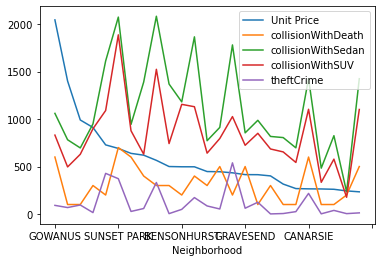

In [55]:
BrooklynFinal.plot()

<AxesSubplot:xlabel='Neighborhood'>

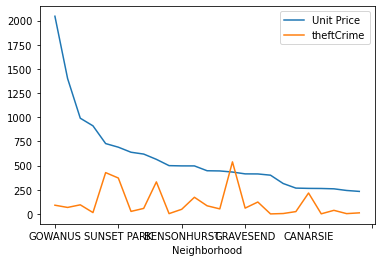

In [56]:
BrooklynFinal[["Unit Price","theftCrime"]].plot()

<AxesSubplot:xlabel='Neighborhood'>

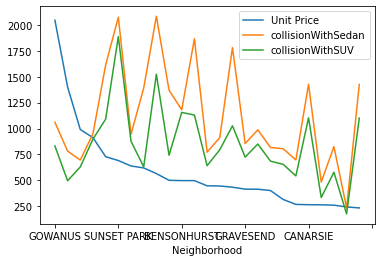

In [57]:
BrooklynFinal[["Unit Price","collisionWithSedan","collisionWithSUV"]].plot()

<AxesSubplot:xlabel='Neighborhood'>

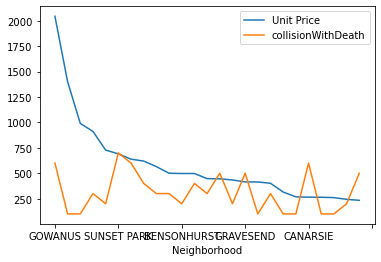

In [58]:
BrooklynFinal[["Unit Price","collisionWithDeath"]].plot()

<AxesSubplot:xlabel='Neighborhood'>

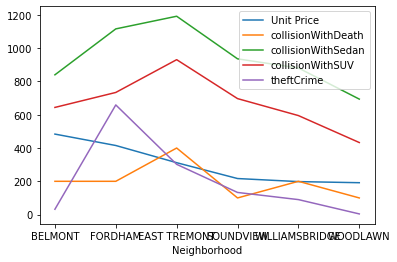

In [59]:
BronxFinal.plot()

<AxesSubplot:xlabel='Neighborhood'>

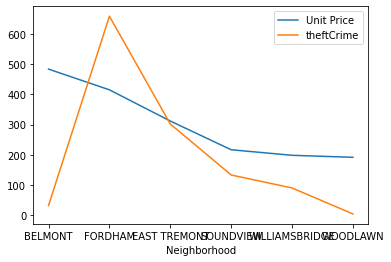

In [60]:
BronxFinal[["Unit Price","theftCrime"]].plot()

<AxesSubplot:xlabel='Neighborhood'>

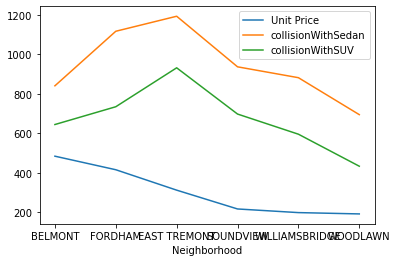

In [61]:
BronxFinal[["Unit Price","collisionWithSedan","collisionWithSUV"]].plot()

<AxesSubplot:xlabel='Neighborhood'>

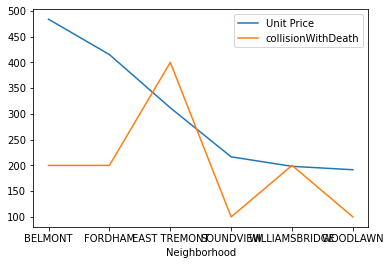

In [62]:
BronxFinal[["Unit Price","collisionWithDeath"]].plot()

<AxesSubplot:xlabel='Neighborhood'>

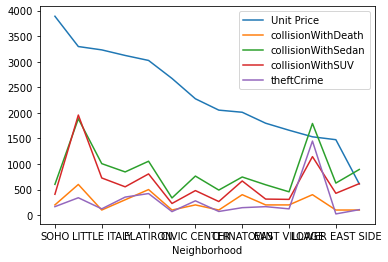

In [63]:
ManhattanFinal.plot()

<AxesSubplot:xlabel='Neighborhood'>

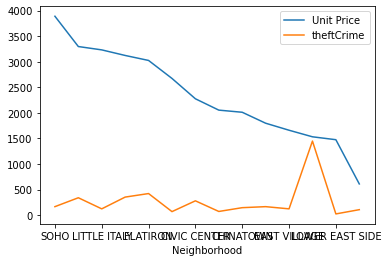

In [64]:
ManhattanFinal[["Unit Price","theftCrime"]].plot()

<AxesSubplot:xlabel='Neighborhood'>

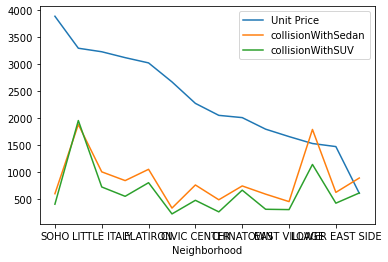

In [65]:
ManhattanFinal[["Unit Price","collisionWithSedan","collisionWithSUV"]].plot()

<AxesSubplot:xlabel='Neighborhood'>

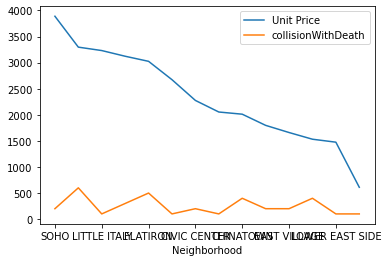

In [66]:
ManhattanFinal[["Unit Price","collisionWithDeath"]].plot()

<AxesSubplot:xlabel='Neighborhood'>

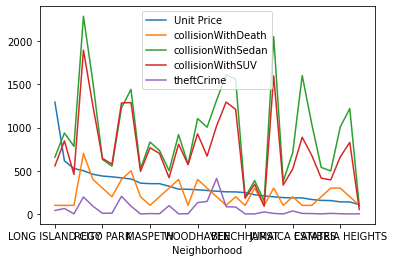

In [67]:
QueensFinal.plot()

<AxesSubplot:xlabel='Neighborhood'>

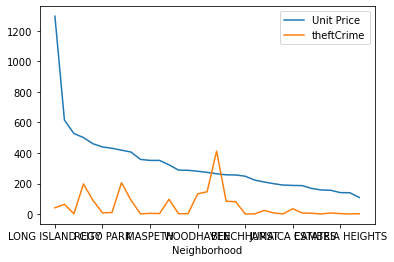

In [68]:
QueensFinal[["Unit Price","theftCrime"]].plot()

<AxesSubplot:xlabel='Neighborhood'>

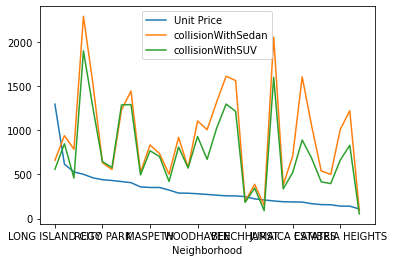

In [69]:
QueensFinal[["Unit Price","collisionWithSedan","collisionWithSUV"]].plot()

<AxesSubplot:xlabel='Neighborhood'>

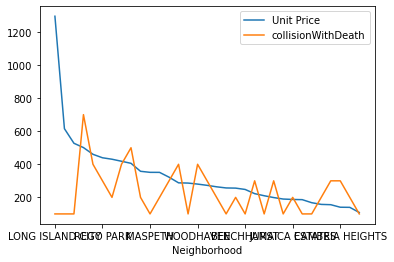

In [70]:
QueensFinal[["Unit Price","collisionWithDeath"]].plot()

# Find target neighborhood
Read collision and crime data with neighborhoods

In [71]:
collisionData_NBH = pd.read_csv('Data/collisionData_NBH.csv')
crimeData_NBH = pd.read_csv('Data/crimeData_NBH.csv')

C:\Users\amper\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3340: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [72]:
print(collisionData_NBH['NBH'].head())
print(crimeData_NBH['NBH'].head())

0      Vinegar Hill
1     East Flatbush
2     East Flatbush
3    Morris Heights
4        Lenox Hill
Name: NBH, dtype: object
0        Mott Haven
1    Lincoln Square
2     Cypress Hills
3        Ocean Hill
4        Morrisania
Name: NBH, dtype: object


The number of crimes and collisions in each neighborhood from 2012 to 2019

In [73]:
nbh_collisions = numCollisions(collisionData_NBH)
nbh_crimes = numCrimes(crimeData_NBH)

Get the change rate of collision and crime data

In [74]:
collision_change_rate = change_rate_by_year(nbh_collisions, 100)
crime_change_rate = change_rate_by_year(nbh_crimes, 50)

In [75]:
crime_change_rate

,Borough,NBH,Overall_Change_Rate,2012-2013,2013-2014,2014-2015,2015-2016,2016-2017,2017-2018,2018-2019
0,BRONX,Mott Haven,-0.011134,0.033934,0.084371,-0.061634,0.093191,-0.119677,-0.095742,0.089464
1,BRONX,Morrisania,-0.200774,0.253552,-0.047946,0.016295,0.020394,-0.083492,-0.300092,-0.176317
2,BRONX,Norwood,0.041554,0.088947,0.035092,-0.271650,0.171870,-0.052450,0.088057,0.090001
3,BRONX,Edenwald,0.394155,0.213017,0.032662,0.031765,0.085206,0.063993,0.167540,-0.000293
4,BRONX,Belmont,-0.031005,-0.077991,-0.091159,-0.116744,-0.003608,0.147337,0.027104,0.051650
...,...,...,...,...,...,...,...,...,...,...
147,QUEENS,Briarwood,-0.158389,0.318231,0.013170,0.230804,-0.108974,0.022551,-0.044536,-0.390877
148,QUEENS,Queensbridge,-0.335500,-0.023775,0.141436,-0.358773,0.160336,-0.127747,-0.101738,-0.199195
149,QUEENS,Far Rockaway,0.156925,-0.166830,0.220822,0.108665,0.064051,-0.005917,0.164028,-0.123348
150,QUEENS,Queensboro Hill,-0.158224,-0.015418,0.080621,-0.343135,-0.111425,0.541943,-0.231930,0.071104


In [76]:
collision_change_rate

,Borough,NBH,Overall_Change_Rate,2012-2013,2013-2014,2014-2015,2015-2016,2016-2017,2017-2018,2018-2019
0,BROOKLYN,Vinegar Hill,-0.208991,-0.275463,-0.124786,0.323180,0.080444,-0.209198,-0.016910,0.078799
1,BROOKLYN,East Flatbush,-0.003073,-0.025650,-0.059505,-0.014775,0.115549,-0.015795,-0.132066,0.115193
2,BROOKLYN,Prospect Heights,-0.181112,0.210396,0.006674,-0.116439,-0.015936,-0.132086,-0.096161,-0.040975
3,BROOKLYN,Borough Park,-0.051974,0.055824,0.010101,-0.033510,-0.065180,0.116524,0.032514,-0.125904
4,BROOKLYN,Cobble Hill,0.060796,-0.015889,-0.008553,-0.068122,0.239854,-0.046487,-0.125979,0.070899
...,...,...,...,...,...,...,...,...,...,...
186,STATEN ISLAND,Grant City,0.009138,-0.129269,0.245862,-0.024115,0.106577,-0.017653,0.057902,-0.105788
187,STATEN ISLAND,Oakwood,-0.006006,-0.008055,0.261476,-0.189185,0.010727,0.004086,-0.075690,-0.004162
188,STATEN ISLAND,Grymes Hill,0.283185,0.490873,0.064441,0.031540,-0.099631,0.118711,0.159417,-0.072514
189,STATEN ISLAND,Tompkinsville,0.633944,0.495187,0.161232,0.127393,-0.051363,0.213116,-0.058292,0.112767


Use the change rate to find our target neighborhoods

In [77]:
collision_tar_nbh = find_tar_nbh(collision_change_rate)
crime_tar_nbh = find_tar_nbh(crime_change_rate)

In [78]:
collision_tar_nbh

,Borough,NBH,Overall_Change_Rate,2012-2013,2013-2014,2014-2015,2015-2016,2016-2017,2017-2018,2018-2019
0,BROOKLYN,Crown Heights,-0.298473,0.070626,-0.044124,0.059349,-0.090892,-0.184621,-0.077511,-0.067210
1,BROOKLYN,Starrett City,0.421855,0.074105,0.111099,0.234787,0.064104,-0.174879,0.144677,-0.018978
2,BRONX,High Bridge,-0.402006,-0.162311,-0.048725,0.094954,-0.207241,-0.191428,0.152634,0.018689
3,BRONX,Mott Haven,0.267124,0.041686,-0.032152,0.158350,-0.017566,-0.027843,-0.043448,0.163804
4,MANHATTAN,Manhattanville,-0.220125,0.091836,-0.007370,-0.007037,-0.133164,-0.167768,-0.016554,-0.087438
5,MANHATTAN,Financial District,0.230314,0.020478,0.048392,-0.058496,0.056316,0.077610,0.119574,0.036785
6,QUEENS,Ravenswood,-0.334970,0.021821,-0.059418,0.035748,-0.166953,-0.113082,-0.217273,0.165696
7,QUEENS,Rockaway Park,0.457887,-0.051988,-0.043527,-0.215250,0.880695,-0.027187,-0.193563,0.254238
8,STATEN ISLAND,Willowbrook,-0.304840,-0.153460,-0.673087,-0.387598,-0.021060,1.164165,-0.198917,0.098653
9,STATEN ISLAND,Tompkinsville,0.633944,0.495187,0.161232,0.127393,-0.051363,0.213116,-0.058292,0.112767


In [79]:
crime_tar_nbh

,Borough,NBH,Overall_Change_Rate,2012-2013,2013-2014,2014-2015,2015-2016,2016-2017,2017-2018,2018-2019
0,BRONX,Hunts Point,-0.247713,-0.067910,-0.049814,-0.165371,0.149817,-0.107463,0.037274,-0.310692
1,BRONX,Woodlawn,0.934711,-0.176438,0.327503,0.208812,-0.073447,0.239476,0.589199,0.091115
2,MANHATTAN,Greenwich Village,-0.170851,-0.203834,0.303798,-0.108785,0.057561,-0.029873,-0.153425,-0.169254
3,MANHATTAN,Lenox Hill,0.585306,-0.027208,-0.048380,0.265259,-0.170829,0.353938,0.212496,0.286732
4,BROOKLYN,Dumbo,-0.253562,-0.282948,0.163699,-0.395099,0.458347,0.371915,-0.285346,-0.299482
5,BROOKLYN,Dyker Heights,0.849559,0.459527,0.231039,-0.167666,0.334058,-0.135722,0.133155,0.374622
6,QUEENS,Queensbridge,-0.335500,-0.023775,0.141436,-0.358773,0.160336,-0.127747,-0.101738,-0.199195
7,QUEENS,Bellaire,0.464312,0.033556,0.041304,0.001027,0.155985,0.050550,0.163720,0.078627


In [80]:
crime_tar_nbh.to_csv('data/crime_target.csv')
collision_tar_nbh.to_csv('data/collisions_target.csv')

# Analyze the correlation between crimes, collisions and property prices
Read the property sales data, collisions and crimes data

In [81]:
nbh_collisions = pd.read_csv('data/collisions_by_year.csv')
nbh_crimes = pd.read_csv('data/crimes_by_year.csv')

In [82]:
QueensData['Neighborhood'] = QueensData['Neighborhood'].str.rstrip()
BronxData['Neighborhood'] = BronxData['Neighborhood'].str.rstrip()
BrooklynData['Neighborhood'] = BrooklynData['Neighborhood'].str.rstrip()
ManhattanData['Neighborhood'] = ManhattanData['Neighborhood'].str.rstrip()
StatenIslandData['Neighborhood'] = StatenIslandData['Neighborhood'].str.rstrip()
collision_tar_nbh['NBH'] = collision_tar_nbh['NBH'].str.upper()
crime_tar_nbh['NBH'] = crime_tar_nbh['NBH'].str.upper()
nbh_collisions['NBH'] = nbh_collisions['NBH'].str.upper()
nbh_crimes['NBH'] = nbh_crimes['NBH'].str.upper()

In [83]:
QueensChangeRate = price_change_rate_by_year(QueensData, 'QUEENS')
BrooklynChangeRate = price_change_rate_by_year(BrooklynData, 'BROOKLYN')
ManhattanChangeRate = price_change_rate_by_year(ManhattanData, 'MANHATTAN')
BronxChangeRate = price_change_rate_by_year(BronxData, 'BRONX')
StatenChangeRate = price_change_rate_by_year(StatenIslandData, 'STATEN ISLAND')

In [84]:
QueensChangeRate.to_csv('data/QueensChangeRate.csv')
BronxChangeRate.to_csv('data/BronxChangeRate.csv')
ManhattanChangeRate.to_csv('data/ManhattanChangeRate.csv')
BrooklynChangeRate.to_csv('data/BrooklynChangeRate.csv')
StatenChangeRate.to_csv('data/StatenChangeRate.csv')

In [85]:
QueensChangeRate = pd.read_csv('data/QueensChangeRate.csv').fillna(0)
BronxChangeRate = pd.read_csv('data/BronxChangeRate.csv').fillna(0)
ManhattanChangeRate = pd.read_csv('data/ManhattanChangeRate.csv').fillna(0)
BrooklynChangeRate = pd.read_csv('data/BrooklynChangeRate.csv').fillna(0)
StatenChangeRate = pd.read_csv('data/StatenChangeRate.csv').fillna(0)

In [86]:
QueensChangeRate

,Unnamed: 0,Borough,NBH,Overall_Change_Rate,2012-2013,2013-2014,2014-2015,2015-2016,2016-2017,2017-2018,2018-2019
0,0,QUEENS,AIRPORT LA GUARDIA,0.331119,0.351902,0.080272,-0.171061,-0.149545,0.146712,0.101081,-0.076468
1,1,QUEENS,ARVERNE,-0.410905,-0.048406,-0.251104,0.018644,-0.173758,0.081034,-0.155763,0.371010
2,2,QUEENS,ASTORIA,0.323060,0.050508,0.147355,-0.056897,0.148283,0.011751,-0.094594,-0.008862
3,3,QUEENS,BAYSIDE,-0.241329,0.008885,0.049149,-0.036201,-0.044410,0.028313,-0.196678,0.059825
4,4,QUEENS,BEECHHURST,-0.166703,-0.011101,-0.019616,0.039597,0.031036,-0.024798,-0.043362,-0.076326
...,...,...,...,...,...,...,...,...,...,...,...
57,57,QUEENS,WOODHAVEN,-0.123225,-0.064974,0.013042,-0.018203,0.069733,0.024065,0.008809,-0.108319
58,58,QUEENS,WOODSIDE,0.347949,0.198129,-0.087884,0.118520,0.058588,0.012423,-0.256131,0.228642
59,59,QUEENS,BREEZY POINT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60,60,QUEENS,QUEENS-UNKNOWN,0.000000,0.000000,-1.010290,0.000000,0.000000,0.000000,0.000000,0.000000


Crime plots

In [87]:
def crimePlot(priceTar: pd.DataFrame, crimeTar: pd.DataFrame, priceNBH: str, crimeNBH: str):
    price = priceTar[priceTar['NBH'].str.contains(priceNBH)].iloc[:, 4:]
    if len(price) > 1:
        price = pd.DataFrame(price.mean()).T
    res = pd.concat([price, crimeTar[crimeTar['NBH'].str.contains(crimeNBH)].iloc[:, 3:]])
    res.index = ['Price', 'Crimes']
    res.T.plot(title=crimeNBH, figsize=(10, 6))

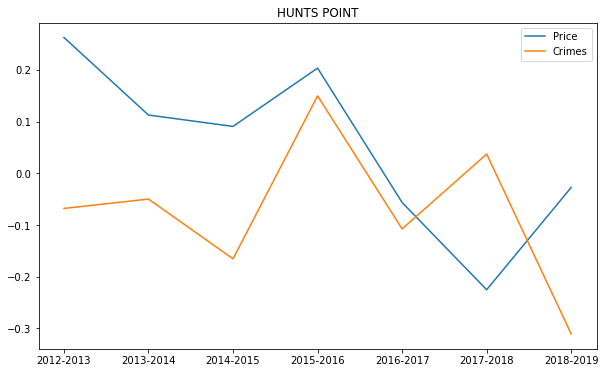

In [88]:
crimePlot(BronxChangeRate, crime_tar_nbh, 'HUNTS POINT', 'HUNTS POINT')

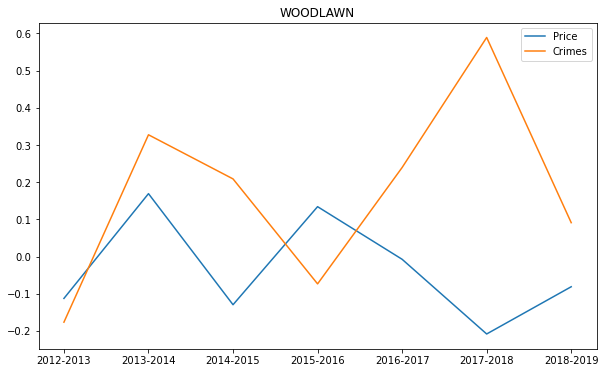

In [89]:
crimePlot(BronxChangeRate, crime_tar_nbh, 'WOODLAWN', 'WOODLAWN')

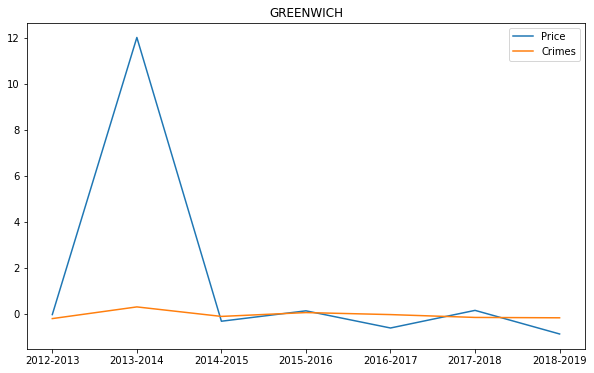

In [90]:
crimePlot(ManhattanChangeRate, crime_tar_nbh, 'GREENWICH', 'GREENWICH')

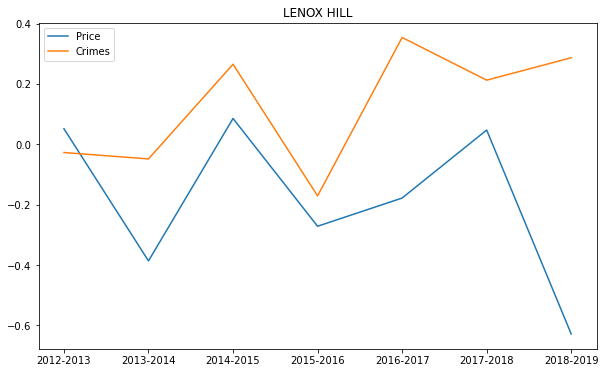

In [91]:
crimePlot(ManhattanChangeRate, crime_tar_nbh, 'UPPER EAST SIDE \(59-79\)', 'LENOX HILL')

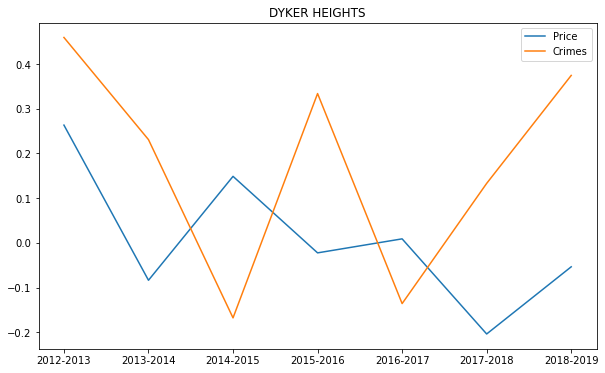

In [92]:
crimePlot(BrooklynChangeRate, crime_tar_nbh, 'DYKER HEIGHTS', 'DYKER HEIGHTS')

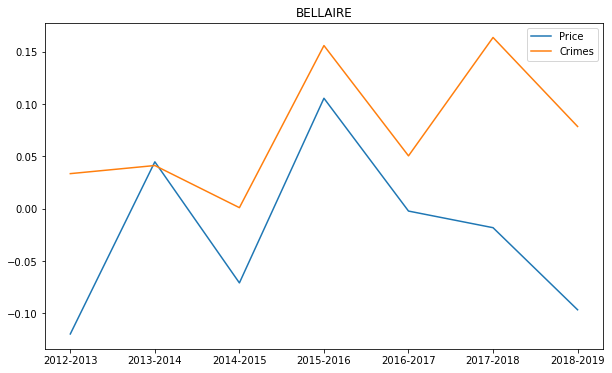

In [93]:
crimePlot(QueensChangeRate, crime_tar_nbh, 'QUEENS VILLAGE', 'BELLAIRE')

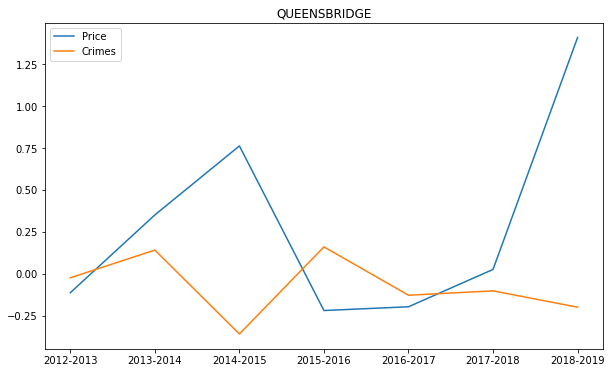

In [94]:
crimePlot(QueensChangeRate, crime_tar_nbh, 'LONG ISLAND CITY', 'QUEENSBRIDGE')

Collision plots

In [95]:
def collisionPlot(priceTar: pd.DataFrame, collisionTar: pd.DataFrame, priceNBH: str, collisionNBH: str):
    price = priceTar[priceTar['NBH'].str.contains(priceNBH)].iloc[:, 4:]
    if len(price) > 1:
        price = pd.DataFrame(price.mean()).T
    res = pd.concat([price, collisionTar[collisionTar['NBH'].str.contains(collisionNBH)].iloc[:, 3:]])
    res.index = ['Price', 'Collisions']
    res.T.plot(title=collisionNBH, figsize=(10, 6))

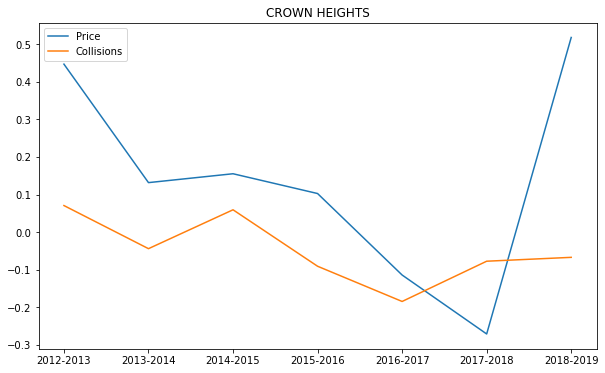

In [96]:
collisionPlot(BrooklynChangeRate, collision_tar_nbh, 'CROWN HEIGHTS', 'CROWN HEIGHTS')

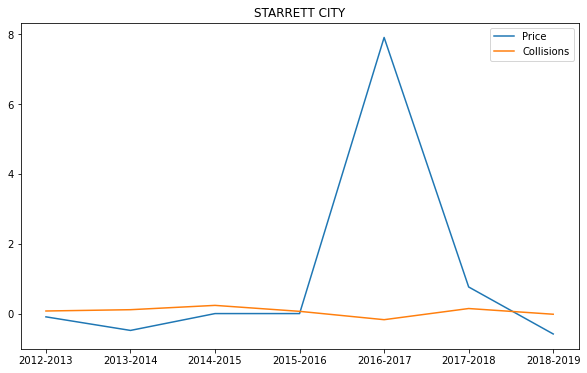

In [97]:
collisionPlot(BrooklynChangeRate, collision_tar_nbh, 'SPRING CREEK', 'STARRETT CITY')

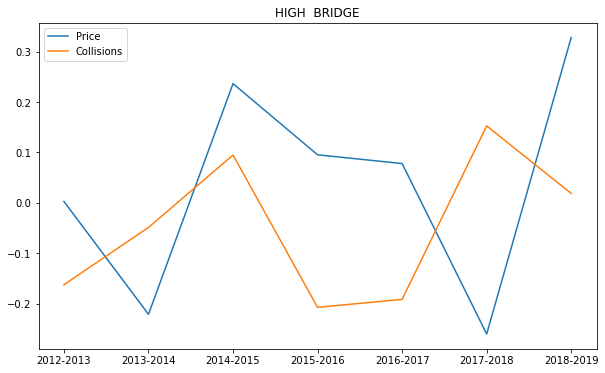

In [98]:
collisionPlot(BronxChangeRate, collision_tar_nbh, 'HIGHBRIDGE', 'HIGH  BRIDGE')

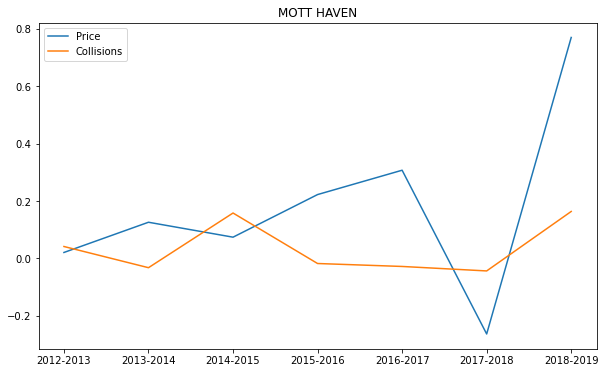

In [99]:
collisionPlot(BronxChangeRate, collision_tar_nbh, 'MOTT HAVEN', 'MOTT HAVEN')

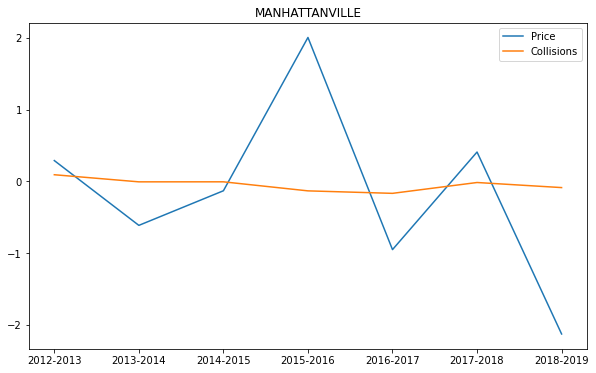

In [100]:
collisionPlot(ManhattanChangeRate, collision_tar_nbh, 'MANHATTAN VALLEY', 'MANHATTANVILLE')

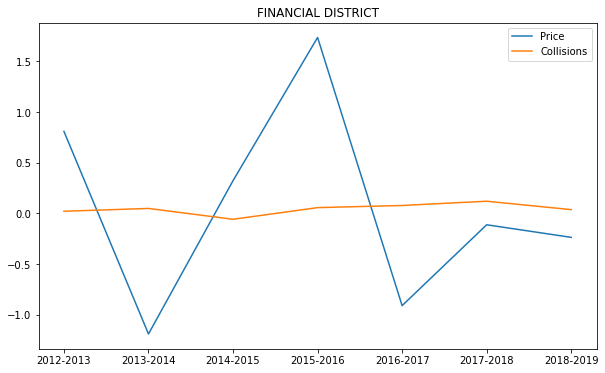

In [101]:
collisionPlot(ManhattanChangeRate, collision_tar_nbh, 'FINANCIAL', 'FINANCIAL DISTRICT')

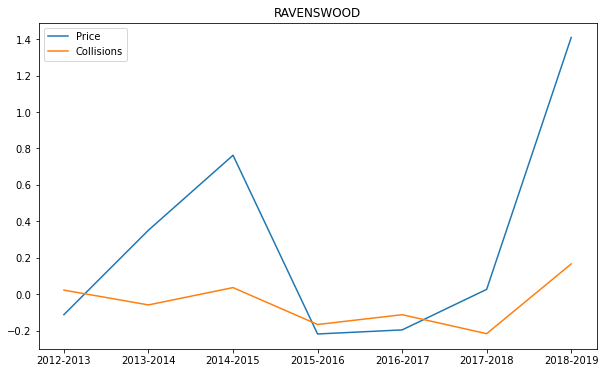

In [102]:
collisionPlot(QueensChangeRate, collision_tar_nbh, 'LONG ISLAND CITY', 'RAVENSWOOD')

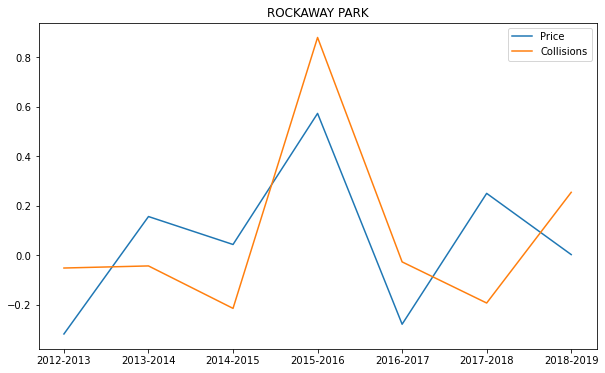

In [103]:
collisionPlot(QueensChangeRate, collision_tar_nbh, 'ROCKAWAY PARK', 'ROCKAWAY PARK')

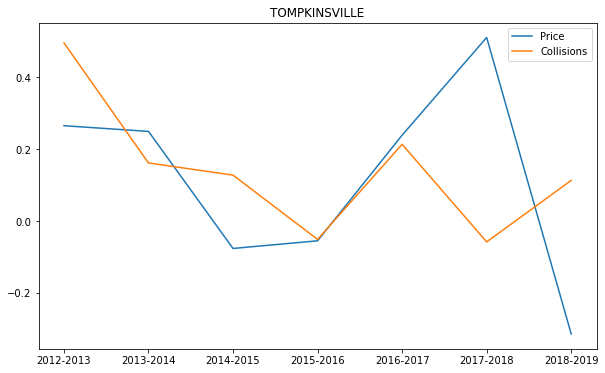

In [104]:
collisionPlot(StatenChangeRate, collision_tar_nbh, 'TOMPKINSVILLE', 'TOMPKINSVILLE')

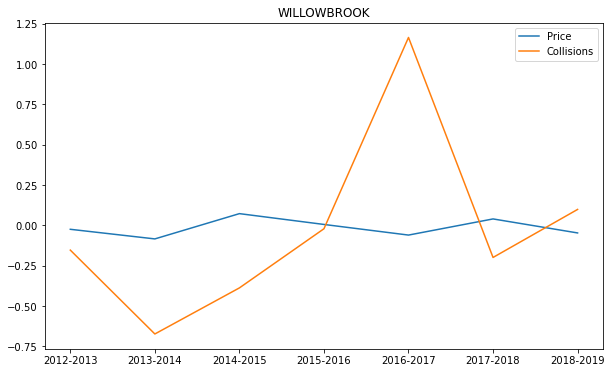

In [105]:
collisionPlot(StatenChangeRate, collision_tar_nbh, 'WILLOWBROOK', 'WILLOWBROOK')

# Calculate correlation for hypothesis 4
We would try to calculate the correlation to quantify the relationship between crime and price for the target neighborhoods

In [106]:
crime_tar_nbh

,Borough,NBH,Overall_Change_Rate,2012-2013,2013-2014,2014-2015,2015-2016,2016-2017,2017-2018,2018-2019
0,BRONX,HUNTS POINT,-0.247713,-0.067910,-0.049814,-0.165371,0.149817,-0.107463,0.037274,-0.310692
1,BRONX,WOODLAWN,0.934711,-0.176438,0.327503,0.208812,-0.073447,0.239476,0.589199,0.091115
2,MANHATTAN,GREENWICH VILLAGE,-0.170851,-0.203834,0.303798,-0.108785,0.057561,-0.029873,-0.153425,-0.169254
3,MANHATTAN,LENOX HILL,0.585306,-0.027208,-0.048380,0.265259,-0.170829,0.353938,0.212496,0.286732
4,BROOKLYN,DUMBO,-0.253562,-0.282948,0.163699,-0.395099,0.458347,0.371915,-0.285346,-0.299482
5,BROOKLYN,DYKER HEIGHTS,0.849559,0.459527,0.231039,-0.167666,0.334058,-0.135722,0.133155,0.374622
6,QUEENS,QUEENSBRIDGE,-0.335500,-0.023775,0.141436,-0.358773,0.160336,-0.127747,-0.101738,-0.199195
7,QUEENS,BELLAIRE,0.464312,0.033556,0.041304,0.001027,0.155985,0.050550,0.163720,0.078627


In [107]:
#combine the record from crime data and price data
def get_target_crimeAndPrice(priceTar: pd.DataFrame, crimeTar: pd.DataFrame, priceNBH: str,crimeNBH: str):
    price = priceTar[priceTar['NBH'].str.contains(priceNBH)].iloc[:, 4:]
    if len(price) > 1:
        price = pd.DataFrame(price.mean()).T
    res = pd.concat([price, crimeTar[crimeTar['NBH'].str.contains(crimeNBH)].iloc[:, 3:]])
    res.index = ['Price', 'Crimes']
    return res.T

In [108]:
# calculate the correlation
def test_correlation(df, var1:str, var2:str):
    # test the correlation between var1  and var 2
    # check normality
    result = {}
    x = df[var1].to_numpy()
    y = df[var2].to_numpy()

    stat, p1 = stats.shapiro(x)
    stat, p2 = stats.shapiro(y)

    alpha = 0.05
    if p1 > alpha and p2 > alpha:
        result["normality"] = "normal distributed"
        # if parametric, use Pearson's r
        coef, p = stats.pearsonr(x, y)
        result["test"] = "Pearson's r"
        result["test value"] = coef
        if p > alpha:
            result["conclusion"]  = "uncorrelated"
        else:
            result["conclusion"] = "correlated"

    else:
        result["normality"] = "not normal distributed"
        # if not parametric, use spearmanr Test
        coef, p = stats.spearmanr(x,y)
        result["test"] = "Spearman's p"
        result["test value"] = coef
        if p > alpha:
            result["conclusion"]  = "uncorrelated"
        else:
            result["conclusion"] = "correlated"


    return result

In [109]:
# function to put correlation into result list
def process_crime_price_correlation(target_price_df:pd.DataFrame,target_crime_df:pd.DataFrame,priceNBH: str, crimeNBH: str,target_borough:str,result_list:list):
    df = get_target_crimeAndPrice(target_price_df,target_crime_df,priceNBH,crimeNBH)
    result = test_correlation(df, "Crimes","Price")
    result["nbh"] = crimeNBH
    result["boroughs"] = target_borough
    result_list.append(result)

In [110]:
# initialize the result list used to store correlation for crime and price
result_crime_price = []

In [111]:
process_crime_price_correlation(BronxChangeRate,crime_tar_nbh,'HUNTS POINT', 'HUNTS POINT','Bronx',result_crime_price)
process_crime_price_correlation(BronxChangeRate,crime_tar_nbh,'WOODLAWN','WOODLAWN','Bronx',result_crime_price)
process_crime_price_correlation(ManhattanChangeRate,crime_tar_nbh,'GREENWICH', 'GREENWICH','Manhattan',result_crime_price)
process_crime_price_correlation(ManhattanChangeRate,crime_tar_nbh,'UPPER EAST SIDE \(59-79\)', 'LENOX HILL','Manhattan',result_crime_price)
# process_crime_price_correlation(BrooklynChangeRate,crime_tar_nbh,'DUMBO', 'DUMBO','Brooklyn',result_crime_price)
process_crime_price_correlation(BrooklynChangeRate,crime_tar_nbh,'DYKER HEIGHTS', 'DYKER HEIGHTS','Brooklyn',result_crime_price)
process_crime_price_correlation(QueensChangeRate,crime_tar_nbh,'QUEENS VILLAGE', 'BELLAIRE','Queens',result_crime_price)
process_crime_price_correlation(QueensChangeRate,crime_tar_nbh,'LONG ISLAND CITY', 'QUEENSBRIDGE','Queens',result_crime_price)

In [112]:
pd.DataFrame(result_crime_price)

,normality,test,test value,conclusion,nbh,boroughs
0,normal distributed,Pearson's r,0.168181,uncorrelated,HUNTS POINT,Bronx
1,normal distributed,Pearson's r,-0.245684,uncorrelated,WOODLAWN,Bronx
2,not normal distributed,Spearman's p,0.464286,uncorrelated,GREENWICH,Manhattan
3,normal distributed,Pearson's r,0.038927,uncorrelated,LENOX HILL,Manhattan
4,normal distributed,Pearson's r,0.046956,uncorrelated,DYKER HEIGHTS,Brooklyn
5,normal distributed,Pearson's r,0.510351,uncorrelated,BELLAIRE,Queens
6,normal distributed,Pearson's r,-0.547298,uncorrelated,QUEENSBRIDGE,Queens


# then we would try to calculate the correlation to quantify the relationship between collision and price for the target neighborhoods

In [113]:
#combine the record from collision data and price data
def get_target_collisionAndPrice(priceTar: pd.DataFrame, collisionTar: pd.DataFrame, priceNBH: str,collisionNBH: str):
    price = priceTar[priceTar['NBH'].str.contains(priceNBH)].iloc[:, 4:]
    if len(price) > 1:
        price = pd.DataFrame(price.mean()).T
    res = pd.concat([price, collisionTar[collisionTar['NBH'].str.contains(collisionNBH)].iloc[:, 3:]])
    res.index = ['Price', 'Collision']
    return res.T

In [114]:
# function to put correlation into result list
def process_collision_price_correlation(target_price_df:pd.DataFrame, target_crime_df:pd.DataFrame, priceNBH: str, collisionNBH: str, target_borough:str, result_list:list):
    df = get_target_collisionAndPrice(target_price_df, target_crime_df, priceNBH, collisionNBH)
    result = test_correlation(df, 'Collision','Price')
    result['nbh'] = collisionNBH
    result['boroughs'] = target_borough
    result_list.append(result)

In [115]:
# initialize the result list used to store correlation for collision and price
result_collision_price = []

In [116]:
process_collision_price_correlation(BrooklynChangeRate, collision_tar_nbh, 'CROWN HEIGHTS', 'CROWN HEIGHTS','Brooklyn',result_collision_price)
process_collision_price_correlation(BrooklynChangeRate, collision_tar_nbh, 'SPRING CREEK', 'STARRETT CITY','Brooklyn',result_collision_price)
process_collision_price_correlation(BronxChangeRate, collision_tar_nbh, 'HIGHBRIDGE', 'HIGH  BRIDGE','Bronx',result_collision_price)
process_collision_price_correlation(BronxChangeRate, collision_tar_nbh, 'MOTT HAVEN', 'MOTT HAVEN','Bronx',result_collision_price)
process_collision_price_correlation(ManhattanChangeRate, collision_tar_nbh, 'MANHATTAN VALLEY', 'MANHATTANVILLE','Manhattan',result_collision_price)
process_collision_price_correlation(ManhattanChangeRate, collision_tar_nbh, 'FINANCIAL', 'FINANCIAL DISTRICT','Manhattan',result_collision_price)
process_collision_price_correlation(QueensChangeRate, collision_tar_nbh, 'LONG ISLAND CITY', 'RAVENSWOOD','Queens',result_collision_price)
process_collision_price_correlation(QueensChangeRate, collision_tar_nbh, 'ROCKAWAY PARK', 'ROCKAWAY PARK','Queens',result_collision_price)
process_collision_price_correlation(StatenChangeRate, collision_tar_nbh, 'TOMPKINSVILLE', 'TOMPKINSVILLE','Staten',result_collision_price)
process_collision_price_correlation(StatenChangeRate, collision_tar_nbh, 'WILLOWBROOK', 'WILLOWBROOK','Staten',result_collision_price)

In [117]:
pd.DataFrame(result_collision_price)

,normality,test,test value,conclusion,nbh,boroughs
0,normal distributed,Pearson's r,0.529725,uncorrelated,CROWN HEIGHTS,Brooklyn
1,not normal distributed,Spearman's p,0.000000,uncorrelated,STARRETT CITY,Brooklyn
2,normal distributed,Pearson's r,-0.120758,uncorrelated,HIGH BRIDGE,Bronx
3,not normal distributed,Spearman's p,0.428571,uncorrelated,MOTT HAVEN,Bronx
4,normal distributed,Pearson's r,0.075363,uncorrelated,MANHATTANVILLE,Manhattan
5,normal distributed,Pearson's r,-0.220062,uncorrelated,FINANCIAL DISTRICT,Manhattan
6,normal distributed,Pearson's r,0.804536,correlated,RAVENSWOOD,Queens
7,not normal distributed,Spearman's p,0.142857,uncorrelated,ROCKAWAY PARK,Queens
8,normal distributed,Pearson's r,0.107506,uncorrelated,TOMPKINSVILLE,Staten
9,normal distributed,Pearson's r,-0.270276,uncorrelated,WILLOWBROOK,Staten
